In [2]:
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import nengo
from nengo.utils.matplotlib import rasterplot
import numpy as np
import tensorflow as tf

import nengo_dl


warnings.simplefilter("ignore")
tf.get_logger().addFilter(lambda rec: "Tracing is expensive" not in rec.msg)

In [3]:
# download MNIST dataset
(train_data, _), (test_data, _) = tf.keras.datasets.mnist.load_data()
# flatten images
train_data = train_data.reshape((train_data.shape[0], -1))
test_data = test_data.reshape((test_data.shape[0], -1))

n_epochs = 2
n_in = train_data.shape[1]

print(train_data.shape)

(60000, 784)


Prophesee dataset

In [4]:
from src.io.psee_loader import PSEELoader

import pathlib
from glob import glob

In [5]:
delta_t = 10000
n = 75
skip = 100

vids = map(PSEELoader, glob("Prophesee_Dataset_n_cars/n-cars_train/cars/*_td.dat"))
# height, width = vid.get_size()
height, width = 120, 120
# vid.seek_time(skip)
event_seqs = [next(vids).load_delta_t(delta_t) for _ in range(n)]
# N = len(event_seqs)

#print(event_seqs[0])

dat = np.zeros((n, delta_t, 30, 30),dtype=np.int8)
for i,block in enumerate(event_seqs):
    for ev in block:
        dat[i,ev[0],ev[1]//4,ev[2]//4] = ev[3]
# for ev in events:
#     dat[ev[0],ev[1],ev[2]] = ev[3]

# dat = decimate(dat,4,axis=2)
# dat = decimate(dat,4,axis=3)

train_data = dat[0:60,:,:,:]
test_data  = dat[60:75,:,:,:]

train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], -1))
test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], -1))

print(train_data.shape, test_data.shape)

(60, 10000, 900) (15, 10000, 900)


Tensorflow Implementation of Autoencoder

In [6]:
import tensorflow as tf
n_hidden = 64
minibatch_size = 8

class auto_enc_tf(tf.keras.Model):

  def __init__(self):
    super().__init__()
    self.dense1 = tf.keras.layers.Dense(n_hidden, activation=tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(n_in, activation=tf.nn.relu)

  def call(self, inputs):
    x = self.dense1(inputs)
    return self.dense2(x)

  def hidden_rep(self, inputs):
    x = self.dense1(inputs)
    y = self.dense2(x)
    return x,y

In [8]:
model = auto_enc_tf()
model.compile(optimizer=tf.optimizers.RMSprop(1e-3), loss=tf.losses.mse)

# run training loop
model.fit(train_data, train_data, epochs=n_epochs, batch_size=minibatch_size)

# evaluate performance on test set
#model.evaluate(test_data, test_data)

# display example output
output = model.predict(test_data[[0]])
plt.figure()
plt.imshow(output[0].reshape((28, 28)))
plt.show()


2022-03-06 20:18:23.814124: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 514.98MiB (rounded to 540000000)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-03-06 20:18:23.814255: W tensorflow/core/common_runtime/bfc_allocator.cc:474] ***************************************************************************************************x


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

Get hidden latent representation of normal 1 hidden layer ANN auto-encoder

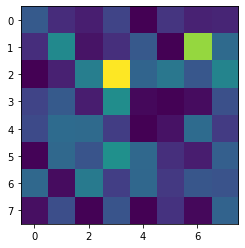

Mean of the hidden space rep: 0.09524098


In [5]:
hidden_rep = model.hidden_rep(test_data[[0]])
plt.figure()
plt.imshow(hidden_rep[0].numpy().reshape((8, 8)))
plt.show()

hidden_rep = hidden_rep[0].numpy()
norm = np.linalg.norm(hidden_rep)
hidden_rep = hidden_rep/norm
print('Mean of the hidden space rep:', hidden_rep.mean())